# Testing pipeline on new dataset

# New Dataset - Binary Model - LEFT VS RIGHT

In [1]:
# ----------------------------- Block 1 ------------------------------------
import numpy as np, mne
from braindecode.datasets import MOABBDataset
from braindecode.preprocessing import (
    preprocess, Preprocessor, exponential_moving_standardize,
    create_windows_from_events
)
from numpy import multiply

mne.set_log_level("ERROR")

SUBJ = 1                      #  ⇦  bytt fritt (1–9 for BNCI2014_001)

ds_raw = MOABBDataset(
    dataset_name="BNCI2014_001",
    subject_ids=[SUBJ]        # ⚠️  kun én forsøksperson
)

# --- sam­me pre-prosessering som i din gamle binære modell ---------------
preprocess(
    ds_raw,
    [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),
        Preprocessor(lambda x: multiply(x, 1e6)),        # V → µV
        Preprocessor('filter', l_freq=8., h_freq=30.),   # 8–30 Hz (MI-bånd)
        Preprocessor(exponential_moving_standardize,
                     factor_new=1e-3, init_block_size=1000),
    ],
)

# --- kutt ett 2 s-vindu fra 0.5 s til 2.5 s etter cue --------------------
sfreq = ds_raw.datasets[0].raw.info['sfreq']           # 250 Hz
t0, t1  = 0.5, 2.5                                     # sek
win_len = int((t1 - t0) * sfreq)                       # 500 samples

windows_ds = create_windows_from_events(
    ds_raw,
    trial_start_offset_samples=int(t0 * sfreq),
    trial_stop_offset_samples =int(t1 * sfreq),
    window_size_samples       =win_len,
    window_stride_samples     =win_len,
    preload=True,
)

print(f"Antall vinduer totalt: {len(windows_ds)}")


<frozen importlib._bootstrap>:219: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:219: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:219: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
C:\Users\aksel\Documents\EEG_master\venv\lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(
C:\Users\aksel\Documents\EEG_master\venv\lib\site-packages\braindecode\preprocessing\preprocess.py:55: UserWarning: Prepro

Antall vinduer totalt: 1728


In [2]:
# ----------------------------- Block 2  (ROBUST SPLIT) --------------------
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

meta = windows_ds.get_metadata()

# ---------- 1)  Behold kun LEFT / RIGHT -----------------------------------
code2name = {0: "LEFT", 1: "RIGHT", 2: "FEET", 3: "TONGUE"}
y_full = meta["target"].map(code2name).to_numpy()

keep   = np.isin(y_full, ["LEFT", "RIGHT"])
X_full = np.stack([w[0] for w in windows_ds])[keep]   # (N, 22, 500)
y_full = y_full[keep]
meta   = meta[keep].reset_index(drop=True)

# ---------- 2)  Finn trenings- og test-run på en robust måte --------------
# BNCI2014_001 har alltid run 3 («train») og run 4 («eval/test»)
if "run" in meta.columns and set(meta["run"].unique()) >= {3, 4}:
    tr_mask = meta["run"] == 3
    te_mask = meta["run"] == 4
else:
    # fallback til session-navn som kan se ut som 0 / 1 eller 0train / 1test …
    sess = meta["session"].astype(str)
    if set(sess.unique()) <= {"0", "1"}:
        tr_mask = sess == "0"
        te_mask = sess == "1"
    else:                             # inneholder ordet “train” / “test”
        tr_mask = sess.str.contains("train", case=False, regex=False)
        te_mask = sess.str.contains("test",  case=False, regex=False)

assert tr_mask.any(), "Fant ingen trenings-vinduer – sjekk filtreringen!"
assert te_mask.any(), "Fant ingen test-vinduer      – sjekk filtreringen!"

X_pre,  y_pre  = X_full[tr_mask], y_full[tr_mask]    #  train-run
X_test, y_test = X_full[te_mask], y_full[te_mask]    #  test-run

print(f"Train-run vinduer: {X_pre.shape[0]}")
print(f"Test-run  vinduer: {X_test.shape[0]}")

# ---------- 3)  80 % train  | 20 % val på trenings-run --------------------
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
tr_idx, val_idx = next(sss.split(X_pre, y_pre))

X_train, y_train = X_pre[tr_idx],  y_pre[tr_idx]
X_val,   y_val   = X_pre[val_idx], y_pre[val_idx]

print("Train:", X_train.shape, np.unique(y_train, return_counts=True))
print("Val:  ", X_val.shape,   np.unique(y_val,   return_counts=True))
print("Test: ", X_test.shape,  np.unique(y_test,  return_counts=True))


Train-run vinduer: 432
Test-run  vinduer: 432
Train: (345, 22, 500) (array(['LEFT', 'RIGHT'], dtype=object), array([172, 173], dtype=int64))
Val:   (87, 22, 500) (array(['LEFT', 'RIGHT'], dtype=object), array([44, 43], dtype=int64))
Test:  (432, 22, 500) (array(['LEFT', 'RIGHT'], dtype=object), array([216, 216], dtype=int64))


In [3]:
# ----------------------------- Block 3  (oversampling) --------------------
from sklearn.utils import resample

labs, counts = np.unique(y_train, return_counts=True)
max_n = counts.max()

X_parts, y_parts = [], []
for lab in labs:
    mask     = y_train == lab
    X_resamp = resample(X_train[mask], replace=True,
                        n_samples=max_n, random_state=42)
    X_parts.append(X_resamp)
    y_parts.append(np.full(max_n, lab))
X_train_bal = np.concatenate(X_parts, axis=0)
y_train_bal = np.concatenate(y_parts, axis=0)

print("Etter oversampling:", np.unique(y_train_bal, return_counts=True))


Etter oversampling: (array(['LEFT', 'RIGHT'], dtype='<U5'), array([173, 173], dtype=int64))


In [4]:
# ----------------------------- Block 4  (pipeline) ------------------------
from pyriemann.estimation      import Covariances
from pyriemann.tangentspace    import TangentSpace
from sklearn.preprocessing     import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.svm               import SVC
from sklearn.pipeline          import Pipeline
from model_utils               import CovTransport   # <- som før

pipe = Pipeline([
    ('cov',    Covariances(estimator='oas')),
    ('align',  CovTransport()),          # beholder RA selv om én subject
    ('ts',     TangentSpace(metric='riemann')),
    ('scaler', StandardScaler()),
    ('fs',     SelectKBest(mutual_info_classif, k=50)),
    ('svm',    SVC(kernel='rbf', C=1.0, gamma='scale',
                   probability=True, random_state=42))
])

pipe.fit(X_train_bal, y_train_bal)


Pipeline(steps=[('cov', Covariances(estimator='oas')),
                ('align', CovTransport()), ('ts', TangentSpace()),
                ('scaler', StandardScaler()),
                ('fs',
                 SelectKBest(k=50,
                             score_func=<function mutual_info_classif at 0x000002072B4FC9D0>)),
                ('svm', SVC(probability=True, random_state=42))])

In [5]:
# ----------------------------- Block 5  (evaluering) ----------------------
from sklearn.metrics import balanced_accuracy_score, classification_report

for name, Xs, ys in [('Val', X_val, y_val),
                     ('Test', X_test, y_test)]:
    yp = pipe.predict(Xs)
    print(f"\n{name} balanced accuracy: {balanced_accuracy_score(ys, yp):.3f}")
    print(classification_report(
        ys, yp, labels=["LEFT", "RIGHT"],
        target_names=["LEFT", "RIGHT"], zero_division=0
    ))



Val balanced accuracy: 0.805
              precision    recall  f1-score   support

        LEFT       0.85      0.75      0.80        44
       RIGHT       0.77      0.86      0.81        43

    accuracy                           0.80        87
   macro avg       0.81      0.81      0.80        87
weighted avg       0.81      0.80      0.80        87


Test balanced accuracy: 0.771
              precision    recall  f1-score   support

        LEFT       0.82      0.70      0.75       216
       RIGHT       0.74      0.84      0.79       216

    accuracy                           0.77       432
   macro avg       0.78      0.77      0.77       432
weighted avg       0.78      0.77      0.77       432



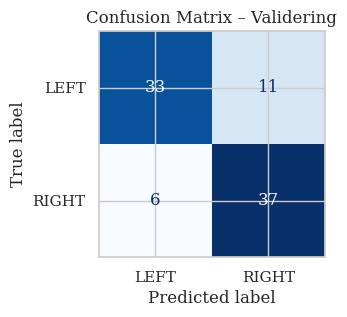

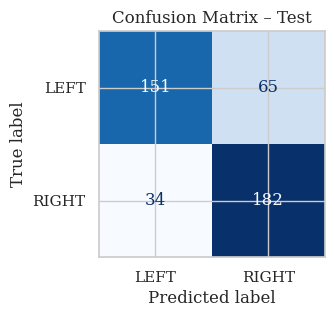

In [6]:
# ----------------------------- Block 6  (confusion matrices) -------------
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ["LEFT", "RIGHT"]

for title, Xs, ys in [("Validering", X_val, y_val),
                      ("Test",       X_test, y_test)]:
    cm   = confusion_matrix(ys, pipe.predict(Xs), labels=labels)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(3.5, 3.5))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix – {title}")
    plt.tight_layout()
    plt.show()


In [7]:
# ----------------------------- Block 7  (lekkasje-vakt) -------------------
tr_set = set(tr_idx)
val_set = set(val_idx)
test_set= set(np.where(te_mask)[0])

print("Train ∩ Val :", len(tr_set & val_set))
print("Train ∩ Test:", len(tr_set & test_set))
print("Val   ∩ Test:", len(val_set & test_set))
assert len(tr_set & val_set) == len(tr_set & test_set) == len(val_set & test_set) == 0
print("✅  Ingen overlapp mellom splittene")


Train ∩ Val : 0
Train ∩ Test: 0
Val   ∩ Test: 0
✅  Ingen overlapp mellom splittene


# Multiclass modell with CSP - Right, Left, Feet, Tongue

In [ ]:
# ----------------------------- Block 1 ------------------------------------
import numpy as np, mne
from braindecode.datasets import MOABBDataset
from braindecode.preprocessing import (
    preprocess, Preprocessor, exponential_moving_standardize,
    create_windows_from_events
)
from numpy import multiply
mne.set_log_level("ERROR")

SUBJ = 3                          # ← bytt om du vil bruke en annen

ds_raw = MOABBDataset(
    dataset_name="BNCI2014_001",
    subject_ids=[SUBJ]            # ⚠️ bare én subject!
)

preprocess(
    ds_raw,
    [
        Preprocessor('pick_types', eeg=True, meg=False, stim=False),
        Preprocessor(lambda x: multiply(x, 1e6)),      # V → µV
        Preprocessor('filter', l_freq=8., h_freq=30.), # 8–30 Hz MI-bånd
        Preprocessor(exponential_moving_standardize,
                     factor_new=1e-3, init_block_size=1000),
    ],
)

sfreq   = ds_raw.datasets[0].raw.info['sfreq']         # 250 Hz
t0, t1  = 0.5, 2.5                                     # 0.5–2.5 s etter cue
win     = int((t1 - t0) * sfreq)                       # 2 s = 500 prøver

windows_ds = create_windows_from_events(
    ds_raw,
    trial_start_offset_samples=int(t0 * sfreq),
    trial_stop_offset_samples =int(t1 * sfreq),
    window_size_samples       =win,
    window_stride_samples     =win,
    preload=True,
)

print("Antall vinduer:", len(windows_ds))


In [ ]:
# ----------------------------- Block 2 ------------------------------------
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

meta = windows_ds.get_metadata()

# ---------- 1)  Fire klasser  ------------------------------------------------
int2name = {0: "LEFT", 1: "RIGHT", 2: "FEET", 3: "TONGUE"}
y = meta["target"].map(int2name).to_numpy()

# ---------- 2)  Feature-tensor ---------------------------------------------
X = np.stack([w[0] for w in windows_ds])         # shape (N, 22, 500)

# ---------- 3)  Finn trenings- og test-sesjon -------------------------------
sess_raw = meta["session"].astype(str)           # f.eks. '0train' / '1test'

if set(sess_raw.unique()) <= {"0", "1"}:
    tr_mask = sess_raw == "0"
    te_mask = sess_raw == "1"
else:                                            # generelt: se etter ordet
    tr_mask = sess_raw.str.contains("train", case=False, regex=False)
    te_mask = sess_raw.str.contains("test",  case=False, regex=False)

# ---------- 4)  Del opp ------------------------------------------------------
X_pre,  y_pre  = X[tr_mask],  y[tr_mask]         # hele train-sesjonen
X_test, y_test = X[te_mask],  y[te_mask]         # hele test-sesjonen

print("Train-session vinduer:", X_pre.shape[0])
print("Test-session vinduer :", X_test.shape[0])

# ---------- 5)  Internt split av train-sesjon  (80 % train | 20 % val) ------
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
tr_idx, val_idx = next(sss.split(X_pre, y_pre))
X_train, y_train = X_pre[tr_idx],  y_pre[tr_idx]
X_val,   y_val   = X_pre[val_idx], y_pre[val_idx]

print("Train:", X_train.shape,  np.unique(y_train, return_counts=True))
print("Val:  ", X_val.shape,    np.unique(y_val,   return_counts=True))
print("Test: ", X_test.shape,   np.unique(y_test,  return_counts=True))


In [ ]:
# ----------------------------- Block 2 b  (lekkasje-sjekk, FIX) -----------------------------
import numpy as np, hashlib

print("\n🔎  Sjekk 1  –  Indeks-overlapp mellom settene")

# te_idx = np.where(te_mask)[0]  gir ndarray med test-indeksene
idx_sets = {
    "train": set(tr_idx),
    "val"  : set(val_idx),
    "test" : set(np.where(te_mask.to_numpy())[0]),
}

for a, A in idx_sets.items():
    for b, B in idx_sets.items():
        if a >= b:      # sjekk bare hver kombinasjon én gang
            continue
        overlap = A & B
        print(f"{a:>5} ∩ {b:<5}: {len(overlap)}  (OK hvis 0)")

print("\n🔎  Sjekk 2  –  Unike trial-ID-er (i_window_in_trial) i hvert sett")
for name, idx in [("train", tr_idx), ("val", val_idx), ("test", np.where(te_mask)[0])]:
    ids   = meta.iloc[idx]["i_window_in_trial"]
    n_dup = ids.duplicated().sum()
    print(f"{name:>5}:  dubbletter i egen liste = {n_dup}")

print("\n🔎  Sjekk 3  –  Hash-sammenligning av selve vindu-dataene")
def md5_set(X_):
    return {hashlib.md5(x.tobytes()).hexdigest() for x in X_}

h_train, h_val, h_test = map(md5_set, (X_train, X_val, X_test))
print("train ∩ val :", len(h_train & h_val))
print("train ∩ test:", len(h_train & h_test))
print("val   ∩ test:", len(h_val & h_test))

print("\n✅  Alle rapporterte tall skal være 0 – da er det ingen datalekkasje.")


In [ ]:
# ----------------------------- Block 3 ------------------------------------
from pyriemann.estimation      import Covariances
from pyriemann.spatialfilters  import CSP
from pyriemann.tangentspace    import TangentSpace
from sklearn.preprocessing     import StandardScaler
from sklearn.pipeline          import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.svm               import SVC

pipe = Pipeline([
    ('cov',    Covariances(estimator='oas')),
    ('csp',    CSP(nfilter=8, log=False)),          # 8 komponenter ⇒ 36 feats
    ('ts',     TangentSpace(metric='riemann')),
    ('scaler', StandardScaler()),
    ('fs',     SelectKBest(mutual_info_classif, k='all')),  # 36 features
    ('svm',    SVC(C=5, gamma='scale', kernel='rbf',
                   probability=False, random_state=42))
])

pipe.fit(X_train, y_train)          # ✅ trener nå uten feil


In [ ]:
# ----------------------------- Block 3 b  (pipeline-sjekk) -----------------------------
from sklearn.utils.metaestimators import _BaseComposition

print("\n🔎  Sjekk 4  –  Hvilke steg ble egentlig trent (fit)?")
for name, step in pipe.named_steps.items():
    fitted = hasattr(step, "fit") and hasattr(step, "__dict__") and bool(step.__dict__)
    print(f"{name:>6}: {'✓ fitted' if fitted else '⨯ IKKE fitted'}")

print("\n🔎  Sjekk 5  –  Standardiseringsparametre (scaler) er basert på train")
scaler = pipe.named_steps["scaler"]
print(" scaler.mean_.shape:", scaler.mean_.shape)
print(" scaler.var_ .shape:", scaler.var_.shape)

print("\n🔎  Sjekk 6  –  Antall støtte-vektorer i SVM (= trenings-eksempler som bestemmer grensen)")
svm = pipe.named_steps["svm"]
print(" #support-vectors:", svm.support_.shape[0])

print("\n⚠️  Hvis du noen gang gjen-kaller .fit() på pipeline med andre data\n"
      "    vil alt over lære på nytt – pass derfor på rekkefølgen.")


In [ ]:
# ----------------------------- Block 4 ------------------------------------
from sklearn.metrics import balanced_accuracy_score, classification_report

for split, Xs, ys in [('Val', X_val, y_val),
                      ('Test', X_test, y_test)]:
    yp = pipe.predict(Xs)
    print(f"\n{split} bal-accuracy: {balanced_accuracy_score(ys, yp):.3f}")
    print(classification_report(
        ys, yp,
        labels=["LEFT","RIGHT","FEET","TONGUE"],
        target_names=["LEFT","RIGHT","FEET","TONGUE"]
    ))


In [ ]:
# ----------------------------- Block «Confusion Matrix» -----------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = ["LEFT", "RIGHT", "FEET", "TONGUE"]       # fast rekkefølge

for split_name, X_split, y_split in [
        ("Validering", X_val,  y_val),
        ("Test",       X_test, y_test)]:

    y_pred = pipe.predict(X_split)
    cm     = confusion_matrix(y_split, y_pred, labels=labels)

    # 1) Skriv som tabell i konsollen
    print(f"\n{split_name}-settet — konfusjonsmatrise")
    print("        " + "  ".join(f"{lab:>6}" for lab in labels))
    for lab, row in zip(labels, cm):
        print(f"{lab:>6}  " + "  ".join(f"{n:6d}" for n in row))

    # 2) Tegn figuren
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(4, 3.5))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"Confusion Matrix — {split_name}")
    plt.tight_layout()
    plt.show()
